## Text Analysis on The Godfather parts (I & II)

## 1. Loading the Text files and storing them into a data frame

In [9]:
import pandas as pd
import os
# Load the scripts (text files)
with open("Godfather_1.txt.txt", "r", encoding="utf-8") as f:
    text_part1 = f.read()

with open("Godfather_2.txt.txt", "r", encoding="utf-8") as f:
    text_part2 = f.read()

# Store into DataFrame
df = pd.DataFrame({
    "Movie": ["Part I", "Part II"],
    "Script": [text_part1, text_part2]
})

df.head()


,Movie,Script
0,Part I,"﻿""THE GODFATHER""\n\n ..."
1,Part II,﻿THE GODFATHER\n\n Part Two\n\nScreenplay by\n...


In [10]:
import nltk
import re
import string
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 2. Cleaning the text files by tokenization method- 
#### this removes numbers, punctuations , common stop words and converts the raw script into clean word tokens

In [11]:
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

tokens_part1 = clean_text(text_part1)
tokens_part2 = clean_text(text_part2)


## 3. SENTIMENT ANALYSIS (VADER)
 #### Objective: Compute sentiment score for each dialogue line and classify them into Positive / Neutral / Negative categories
  #### VADER calculates polarity score if output is >0.05 sentiment is positive if <-0.05 then sentiment is negative , otherwise neutral

In [12]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def sentiment_score(text):
    return sia.polarity_scores(text)['compound']

df["Sentiment"] = df["Script"].apply(sentiment_score)
df["Sentiment_Label"] = df["Sentiment"].apply(
    lambda x: "Positive" if x > 0.05 else ("Negative" if x < -0.05 else "Neutral")
)

df


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Movie,Script,Sentiment,Sentiment_Label
0,Part I,"﻿""THE GODFATHER""\n\n ...",1.0,Positive
1,Part II,﻿THE GODFATHER\n\n Part Two\n\nScreenplay by\n...,1.0,Positive


## 4. WORD FREQUENCY
#### Here I have identified the top 10 most frequent words spoken in both the films and compared the frequency patterns across both the films
#### Counter() counnts the frequency of each word

In [13]:
from collections import Counter

freq_part1 = Counter(tokens_part1)
freq_part2 = Counter(tokens_part2)

top_10_part1 = freq_part1.most_common(10)
top_10_part2 = freq_part2.most_common(10)

top_10_part1, top_10_part2


([('michael', 449),
  ('corleone', 204),
  ('sonny', 201),
  ('hagen', 177),
  ('day', 170),
  ('int', 118),
  ('kay', 118),
  ('car', 116),
  ('man', 108),
  ('clemenza', 108)],
 [('michael', 517),
  ('view', 318),
  ('hagen', 196),
  ('vito', 183),
  ('sicilian', 162),
  ('man', 151),
  ('pentangeli', 149),
  ('fredo', 147),
  ('day', 141),
  ('corleone', 126)])

## 5. CORRELATION OF WORD USAGE BETWEEN THE FILMS
#### Match common vocabulary and create frequency vectors. By applying Pearson correlation output interprets similarity in language use.

In [14]:
common_words = list(set(freq_part1.keys()).intersection(set(freq_part2.keys())))

vector1 = [freq_part1[word] for word in common_words]
vector2 = [freq_part2[word] for word in common_words]

correlation = pd.Series(vector1).corr(pd.Series(vector2))
correlation


0.7930399377191654

## 6. CHARACHTER LEVEL ANALYSIS
#### Here I have calculated how often the leading charachters "Michael" and "Vito" appear in dialogue in both the films indicating influence and stage presence

In [15]:
def count_character_lines(text, character):
    return text.lower().count(character.lower())

characters = ["michael", "vito"]

for char in characters:
    print(char, 
          count_character_lines(text_part1, char),
          count_character_lines(text_part2, char))


michael 476 568
vito 1 212


## 7. TOPIC MODELLING USING LDA

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer(stop_words="english")
dtm = vectorizer.fit_transform([text_part1, text_part2])

lda = LatentDirichletAllocation(n_components=2, random_state=42)
lda.fit(dtm)

for i, topic in enumerate(lda.components_):
    print(f"Topic {i}:")
    print([vectorizer.get_feature_names_out()[index]
           for index in topic.argsort()[-10:]])


Topic 0:
['1946', 'mccluskey', 'spring', '1955', 'bonasera', 'paulie', 'nite', 'mall', 'winter', '1945']
Topic 1:
['ext', 'int', 'kay', 'man', 'day', 'corleone', 'view', 'hagen', 'don', 'michael']


## What patterns do we see?
##### Years → 1945, 1946, 1955
##### Characters → Bonasera (funeral parlor man), Paulie
##### McCluskey → corrupt police captain
##### Season/time words → spring, winter, nite
##### Mall → The Corleone Mall (compound)

### What does this mean?

#### These words come from Part I, especially the early sequences capturing historical, setting-based, and plot-establishing elements such as the timeline of events (1945–1955), the characters involved in the first major conflict (McCluskey, Paulie) , the environmental descriptions (winter, spring, nite) and the opening scenes at the Corleone mall compoundThe iconic opening with Bonasera’s plea

## Interpretation:
#### Topic 0 represents the historical and narrative setup of The Godfather universe—early plot events, timeframe (1945–1955), and characters tied to the initial conflict in Part I.

## What patterns do we see?

### Script formatting words → ext, int, day, view
### (These come from scene headings: INT. OFFICE – DAY, EXT. STREET – NIGHT)

### Main characters → Michael, Don, Kay, Hagen
### General human terms → man

## What does this mean?
#### This topic is capturing the main dramatic storyline and character interactions — especially those involving: Michael Corleone,Tom HagenKay Adams & Don Corleone.These words are highly frequent in dialogue-heavy parts of the script .Scene direction words (EXT, INT, DAY) indicate dialogue and action-driven sections of the movie.

## Interpretation:
#### Topic 1 represents the central character-driven narrative—Michael’s storyline, key interactions, and core scenes involving major characters.

## EMOTION EVOLUTION PLOTS: visualising the overall emotional trajectory (comparison between 2 films)

Michael lines Part I: 585
Michael lines Part II: 657
pos1 length: 585
pos2 length: 657


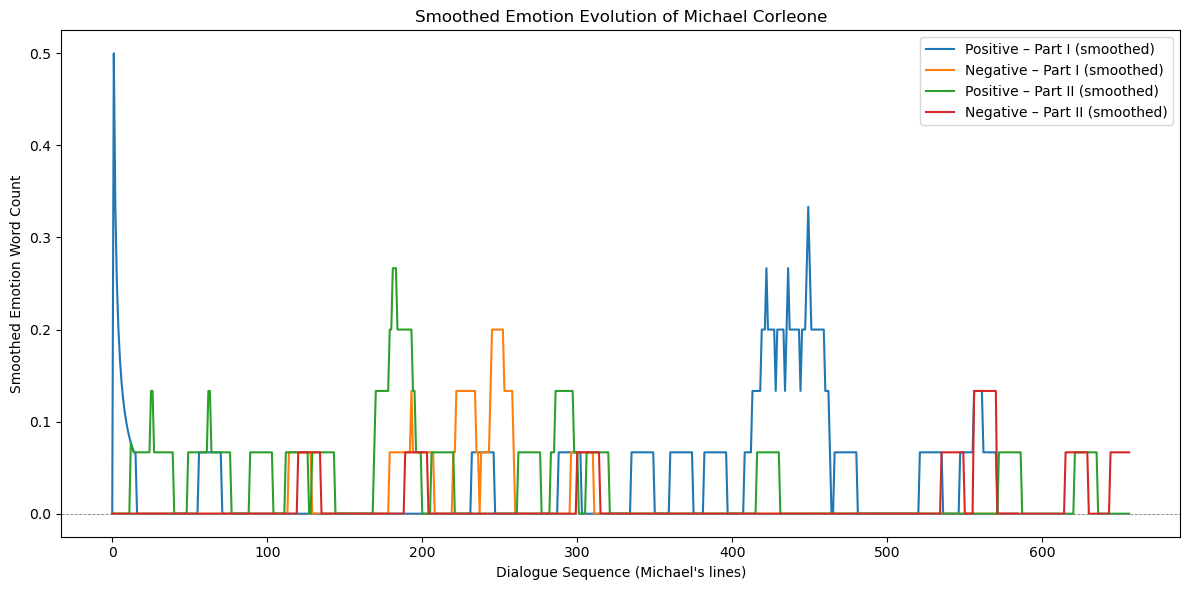

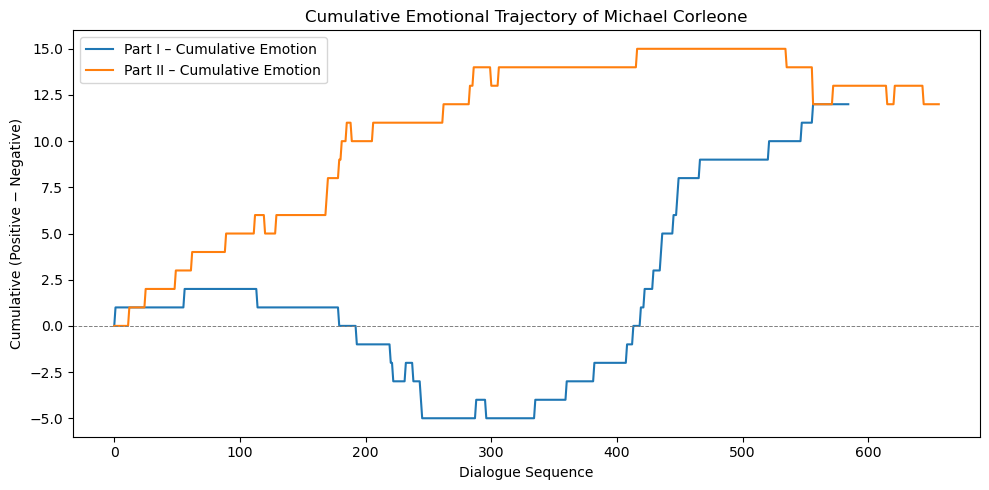

In [23]:
# ===============================
# STEP 0: IMPORTS
# ===============================
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ===============================
# STEP 1: CHECK df EXISTS
# ===============================
# df must have columns: 'Movie', 'Script'
assert 'Movie' in df.columns and 'Script' in df.columns, "df must contain Movie and Script columns"

# ===============================
# STEP 2: GET RAW TEXT
# ===============================
text_part1 = df.loc[df['Movie'] == 'Part I', 'Script'].values[0]
text_part2 = df.loc[df['Movie'] == 'Part II', 'Script'].values[0]

# ===============================
# STEP 3: EXTRACT MICHAEL DIALOGUE (ROBUST)
# ===============================
def extract_dialogue(text, character):
    lines = text.split("\n")
    dialogue = []
    capture = False

    for line in lines:
        stripped = line.strip()

        # Detect MICHAEL cue
        if re.match(rf"^{character}\b", stripped, re.IGNORECASE):
            capture = True
            continue

        # Stop when another cue or blank line starts
        if capture:
            if stripped == "" or re.match(r"^[A-Z][A-Z\s\(\)\.']+$", stripped):
                capture = False
            else:
                dialogue.append(stripped.lower())

    return dialogue

michael_lines_part1 = extract_dialogue(text_part1, "MICHAEL")
michael_lines_part2 = extract_dialogue(text_part2, "MICHAEL")

print("Michael lines Part I:", len(michael_lines_part1))
print("Michael lines Part II:", len(michael_lines_part2))

# ===============================
# STEP 4: DEFINE EMOTION LEXICONS
# ===============================
positive_words = {
    "family", "love", "trust", "peace", "safe", "hope", "together", "protect"
}

negative_words = {
    "kill", "death", "blood", "war", "betray", "enemy", "revenge", "hate", "fear"
}

# ===============================
# STEP 5: COUNT EMOTIONS PER LINE
# ===============================
def count_emotions(lines, pos_words, neg_words):
    pos_counts = []
    neg_counts = []

    for line in lines:
        tokens = re.findall(r'\b\w+\b', line)
        pos_counts.append(sum(1 for t in tokens if t in pos_words))
        neg_counts.append(sum(1 for t in tokens if t in neg_words))

    return pos_counts, neg_counts

# ---- THIS IS WHERE pos1 IS CREATED ----
pos1, neg1 = count_emotions(michael_lines_part1, positive_words, negative_words)
pos2, neg2 = count_emotions(michael_lines_part2, positive_words, negative_words)

print("pos1 length:", len(pos1))
print("pos2 length:", len(pos2))

# ===============================
# STEP 6: CREATE df1 AND df2  (THIS FIXES YOUR ERROR)
# ===============================
df1 = pd.DataFrame({"pos": pos1, "neg": neg1})
df2 = pd.DataFrame({"pos": pos2, "neg": neg2})

# ===============================
# STEP 7: SMOOTHED EMOTION EVOLUTION PLOT
# ===============================
window = 15

df1_sm = df1.rolling(window, min_periods=1).mean()
df2_sm = df2.rolling(window, min_periods=1).mean()

plt.figure(figsize=(12,6))

plt.plot(df1_sm['pos'], label="Positive – Part I (smoothed)")
plt.plot(df1_sm['neg'], label="Negative – Part I (smoothed)")
plt.plot(df2_sm['pos'], label="Positive – Part II (smoothed)")
plt.plot(df2_sm['neg'], label="Negative – Part II (smoothed)")

plt.axhline(0, color='gray', linestyle='--', linewidth=0.6)
plt.xlabel("Dialogue Sequence (Michael's lines)")
plt.ylabel("Smoothed Emotion Word Count")
plt.title("Smoothed Emotion Evolution of Michael Corleone")
plt.legend()
plt.tight_layout()
plt.show()

# ===============================
# STEP 8: CUMULATIVE EMOTIONAL TRAJECTORY
# ===============================
cum1 = (df1['pos'] - df1['neg']).cumsum()
cum2 = (df2['pos'] - df2['neg']).cumsum()

plt.figure(figsize=(10,5))
plt.plot(cum1, label="Part I – Cumulative Emotion")
plt.plot(cum2, label="Part II – Cumulative Emotion")

plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
plt.xlabel("Dialogue Sequence")
plt.ylabel("Cumulative (Positive − Negative)")
plt.title("Cumulative Emotional Trajectory of Michael Corleone")
plt.legend()
plt.tight_layout()
plt.show()


## FIG 1: Smoothed Emotion Evolution of Michael Corleone
 #### This figure plots the smoothed evolution of emotional language used by Michael Corleone across The Godfather Part I and Part II.
 #### Specifically, it shows: Positive emotion word counts (smoothed) & Negative emotion word counts (smoothed) for Part I and Part II separately. Each curve is a 15-line rolling average, which smooths out noise from individual dialogue lines.
 #### X-axis (Dialogue Sequence) represents the chronological order of Michael’s dialogue lines in each film. A higher value means later in the movie.    Y-axis (Smoothed Emotion Word Count) represents the average number of positive or negative emotion words per dialogue line over the previous 15 lines.
 ##### Blue: Positive emotion in Part I, 
 ##### Orange: Negative emotion in Part IGreen: Positive emotion in Part II
 ##### Red: Negative emotion in Part II
### A rise in a curve indicates a cluster of emotionally charged dialogue rather than a single emotional line
### Key interpretation
#### In Part I, Michael’s dialogue shows greater emotional variation, with both positive and negative spikes. This reflects his internal conflict and gradual involvement in the family business.
#### In Part II, positive emotion spikes are smaller and less frequent, while negative emotion clusters are more pronounced and persistent.The reduced volatility in Part II suggests Michael becomes emotionally controlled, colder, and more calculated.

## FIG 2: Cumulative Emotional Trajectory of Michael Corleone .
#### This figure plots the cumulative emotional balance of Michael’s dialogue across each film. At each dialogue line, it adds:
#### Positive words
##### −
#### Negative words
#### Positive words−Negative words
### This creates a running emotional total over the course of the movie.

#### X-axis (Dialogue Sequence)
##### Chronological order of Michael’s dialogue lines.
#### Y-axis (Cumulative Emotional Balance)
##### Net emotional score up to that point in the film.

### Meaning of the curves
#### Upward slope → Michael’s dialogue is becoming more positive overall
#### Downward slope → Michael’s dialogue is becoming more negative overall
#### Flat segments → Emotionally neutral or controlled speech

## Key interpretation
#### In Part I, the cumulative curve fluctuates, reflecting Michael’s emotional struggle and moments of moral hesitation.

In Part II, the cumulative curve shows a stronger downward trend, indicating a sustained accumulation of negative emotional language.

The sharper decline in Part II demonstrates emotional hardening and moral decay.